In [ ]:
#!git clone https://github.com/fany02656/Typicality_project.git

Cloning into 'Typicality_project'...
remote: Enumerating objects: 246, done.
remote: Counting objects: 100% (152/152), done.
remote: Compressing objects: 100% (149/149), done.
remote: Total 246 (delta 3), reused 150 (delta 2), pack-reused 94
Receiving objects: 100% (246/246), 19.76 MiB | 22.71 MiB/s, done.
Resolving deltas: 100% (3/3), done.


In [1]:
import torch
model = torch.hub.load('pytorch/vision:v0.9.0', 'googlenet', pretrained=True)
model.eval()

Downloading: "https://github.com/pytorch/vision/archive/v0.9.0.zip" to /root/.cache/torch/hub/v0.9.0.zip
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth


GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [2]:
from PIL import Image
from torchvision import transforms
import os

path='/content/drive/MyDrive/typicality/Typicality_project/All_Cropped'
images={}
directory=['Mountain', 'Beach', 'Mug', 'Banana', 
           'Car', 'Plane', 'Lighthouse', 'Church']

for dir in directory:
  images[dir]=[file for file in os.listdir(path+'/'+dir)]

In [3]:
'''
from PIL import Image
from torchvision import transforms
import os

path='/content/drive/MyDrive/typicality/Typicality_project/Image'
images={}
directory=['Landscape_Scenery/Mountain', 'Landscape_Scenery/Beach', 'Daily_Object/Mug', 'Daily_Object/Banana', 
           'Vehicle/Car', 'Vehicle/Plane', 'Architecture/Lighthouse', 'Architecture/Church']

for dir in directory:
  images[dir]=[file for file in os.listdir(path+'/'+dir)]
'''

In [4]:
preprocess = transforms.Compose([
    #transforms.Resize(256),
    #transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [5]:
#type prob cate+filename
all_img={'type':[], 'typicality_score': [], 'dir':[],'top5_labels':[]}

In [6]:
with open("/content/drive/MyDrive/typicality/imagenet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]

In [7]:
for cate, filename in images.items():
  for f in filename:
    dir=os.path.join(path,cate,f)
    img=Image.open(dir)
    print(dir)
    #print(img.size)
    input_tensor=preprocess(img)
    input_batch = input_tensor.unsqueeze(0)

    if torch.cuda.is_available():
      input_batch= input_batch.to('cuda')
      model.to('cuda')

    with torch.no_grad():
      output = model(input_batch)

    probabilities = torch.nn.functional.softmax(output[0], dim=0)
    typ_score=round(float(probabilities.max()*100),1)
    top5_prob, top5_catid = torch.topk(probabilities, 5)
    temp = {}
    for i in range(top5_prob.size(0)):
      temp[categories[top5_catid[i]]] = top5_prob[i].item()
    
    all_img['top5_labels'].append(temp)

    all_img['dir'].append(dir)
    all_img['typicality_score'].append(typ_score)
    if 'Mountain' in cate:
      all_img['type'].append('Mountain')
    if 'Beach' in cate:
      all_img['type'].append('Beach')
    if 'Mug' in cate:
      all_img['type'].append('Mug')
    if 'Banana' in cate:
      all_img['type'].append('Banana')
    if 'Car' in cate:
      all_img['type'].append('Car')
    if 'Plane' in cate:
      all_img['type'].append('Plane')
    if 'Lighthouse' in cate:
      all_img['type'].append('Lighthouse')
    if 'Church' in cate:
      all_img['type'].append('Church')

    #print('Typicality of ',f, ' = ',probabilities.max()*100)

/content/drive/MyDrive/typicality/Typicality_project/Image/Landscape_Scenery/Mountain/2.jpg
/content/drive/MyDrive/typicality/Typicality_project/Image/Landscape_Scenery/Mountain/5.jpg
/content/drive/MyDrive/typicality/Typicality_project/Image/Landscape_Scenery/Mountain/9.jpg
/content/drive/MyDrive/typicality/Typicality_project/Image/Landscape_Scenery/Mountain/8.jpg
/content/drive/MyDrive/typicality/Typicality_project/Image/Landscape_Scenery/Mountain/1.jpg
/content/drive/MyDrive/typicality/Typicality_project/Image/Landscape_Scenery/Mountain/6.jpg
/content/drive/MyDrive/typicality/Typicality_project/Image/Landscape_Scenery/Mountain/11.jpg
/content/drive/MyDrive/typicality/Typicality_project/Image/Landscape_Scenery/Mountain/10.jpg
/content/drive/MyDrive/typicality/Typicality_project/Image/Landscape_Scenery/Mountain/16.jpg
/content/drive/MyDrive/typicality/Typicality_project/Image/Landscape_Scenery/Mountain/4.jpg
/content/drive/MyDrive/typicality/Typicality_project/Image/Landscape_Scenery/

In [8]:
import pandas as pd
all_img_df=pd.DataFrame(all_img)
all_img_df.head()
#len(all_img_df)

,type,typicality_score,dir,top5_labels
0,Mountain,85.1,/content/drive/MyDrive/typicality/Typicality_p...,"{'volcano': 0.8511720895767212, 'promontory': ..."
1,Mountain,67.4,/content/drive/MyDrive/typicality/Typicality_p...,"{'alp': 0.673840343952179, 'valley': 0.1376409..."
2,Mountain,31.3,/content/drive/MyDrive/typicality/Typicality_p...,"{'alp': 0.31291672587394714, 'valley': 0.16099..."
3,Mountain,17.2,/content/drive/MyDrive/typicality/Typicality_p...,"{'valley': 0.17231088876724243, 'alp': 0.13140..."
4,Mountain,64.2,/content/drive/MyDrive/typicality/Typicality_p...,"{'lakeside': 0.6420929431915283, 'boathouse': ..."


In [ ]:
all_img_df['type'].value_counts()

Banana        16
Beach         16
Mug           16
Car           16
Lighthouse    16
Mountain      16
Church        16
Plane         16
Name: type, dtype: int64

In [9]:
all_img_df['7_score']=round(all_img_df['typicality_score']*7/100,1)
all_img_df.head()

,type,typicality_score,dir,top5_labels,7_score
0,Mountain,85.1,/content/drive/MyDrive/typicality/Typicality_p...,"{'volcano': 0.8511720895767212, 'promontory': ...",6.0
1,Mountain,67.4,/content/drive/MyDrive/typicality/Typicality_p...,"{'alp': 0.673840343952179, 'valley': 0.1376409...",4.7
2,Mountain,31.3,/content/drive/MyDrive/typicality/Typicality_p...,"{'alp': 0.31291672587394714, 'valley': 0.16099...",2.2
3,Mountain,17.2,/content/drive/MyDrive/typicality/Typicality_p...,"{'valley': 0.17231088876724243, 'alp': 0.13140...",1.2
4,Mountain,64.2,/content/drive/MyDrive/typicality/Typicality_p...,"{'lakeside': 0.6420929431915283, 'boathouse': ...",4.5


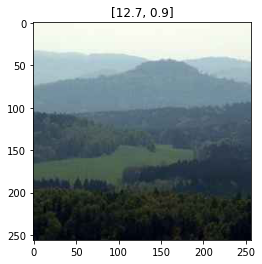

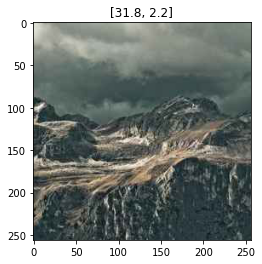

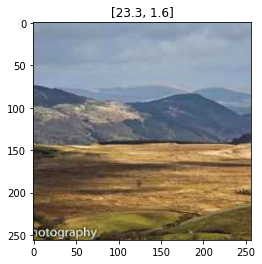

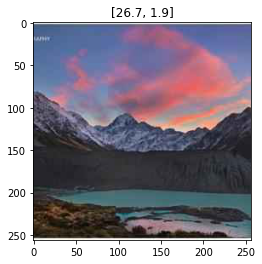

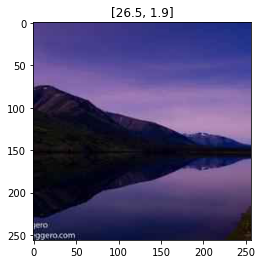

In [ ]:
import matplotlib.pyplot as plt
score=[]
for i in range(5):
  dir=all_img_df['dir'][i]
  score.append([all_img_df['typicality_score'][i], all_img_df['7_score'][i]])
  img=Image.open(dir)
  plt.imshow(img)
  plt.title(score[i])
  plt.show()

In [10]:
all_img_df.to_csv('google_withlabel.csv')

(array([2., 1., 1., 0., 0., 1., 4., 3., 3., 1.]),
 array([16.6 , 23.14, 29.68, 36.22, 42.76, 49.3 , 55.84, 62.38, 68.92,
        75.46, 82.  ]),
 <a list of 10 Patch objects>)

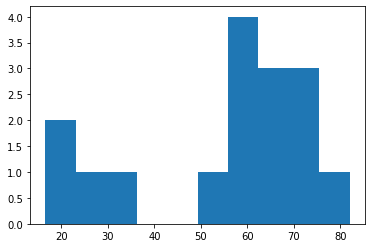

In [12]:
import matplotlib.pyplot as plt

mount=all_img_df[all_img_df['type']=='Beach']
plt.hist(mount['typicality_score'])